# Multilayer Percepton with Feature Removal

In [98]:
import numpy as np
import joblib
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm


from sklearn.model_selection import GridSearchCV, LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.inspection import permutation_importance
from sklearn.base import clone

In [99]:
# Load Data
X_train_input = joblib.load("Data/Xtrain1.pkl")
Y_train_input = np.load('Data/Ytrain1.npy')

print(X_train_input.shape)
print(Y_train_input.shape)

(700, 2)
(700,)


In [100]:
# Extract patient IDs
patient_ids = X_train_input["Patient_Id"].values

# Split into train/test (patients 1–3 for test)
mask_test = np.isin(patient_ids, [1, 2, 3])
mask_train = ~np.isin(patient_ids, [1, 2, 3])

X_train_df = X_train_input[mask_train]
Y_train = Y_train_input[mask_train]

X_test_df = X_train_input[mask_test]
Y_test = Y_train_input[mask_test]

# Extract feature arrays
X_train = np.vstack(X_train_df["Skeleton_Features"].values)
X_test = np.vstack(X_test_df["Skeleton_Features"].values)


In [101]:
# Get train groups
groups_train = X_train_df["Patient_Id"].values 

# Scale Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [102]:
# Define MLP Model and Hyperparameter Grid
mlp = MLPClassifier(max_iter=600, random_state=42)

# Standart
param_grid = {
    'hidden_layer_sizes': [(64,), (128,), (128, 64), (256, 128)],
    'alpha': [0.00001, 0.0001, 0.001],
    'learning_rate_init': [0.001, 0.01],
    'activation': ['relu', 'tanh']
}

cv = LeaveOneGroupOut()

grid_search = GridSearchCV(
    estimator=mlp,
    param_grid=param_grid,
    cv=cv.split(X_train_scaled, Y_train, groups=groups_train),
    scoring='f1_macro',
    n_jobs=-1,
    verbose=2
)

In [103]:
# Hyperparameter Cross-Validation 
print("Running grid search...")
grid_search.fit(X_train_scaled, Y_train)

print("\nBest parameters found:")
print(grid_search.best_params_)
print(f"Best CV F1-macro: {grid_search.best_score_:.4f}")

Running grid search...
Fitting 11 folds for each of 48 candidates, totalling 528 fits
[CV] END activation=relu, alpha=1e-05, hidden_layer_sizes=(64,), learning_rate_init=0.01; total time=   0.2s
[CV] END activation=relu, alpha=1e-05, hidden_layer_sizes=(64,), learning_rate_init=0.001; total time=   0.5s
[CV] END activation=relu, alpha=1e-05, hidden_layer_sizes=(64,), learning_rate_init=0.01; total time=   0.2s
[CV] END activation=relu, alpha=1e-05, hidden_layer_sizes=(64,), learning_rate_init=0.01; total time=   0.2s
[CV] END activation=relu, alpha=1e-05, hidden_layer_sizes=(64,), learning_rate_init=0.01; total time=   0.3s
[CV] END activation=relu, alpha=1e-05, hidden_layer_sizes=(64,), learning_rate_init=0.01; total time=   0.2s
[CV] END activation=relu, alpha=1e-05, hidden_layer_sizes=(64,), learning_rate_init=0.01; total time=   0.2s
[CV] END activation=relu, alpha=1e-05, hidden_layer_sizes=(64,), learning_rate_init=0.001; total time=   0.6s
[CV] END activation=relu, alpha=1e-05, h

In [104]:
# Evaluate on Test Set 
best_model = grid_search.best_estimator_

Y_pred_initial = best_model.predict(X_test_scaled)
f1_score_initial = f1_score(Y_test, Y_pred_initial, average='macro')

print(f"\nTest F1-score (macro): {f1_score_initial:.4f}")


Test F1-score (macro): 0.8052


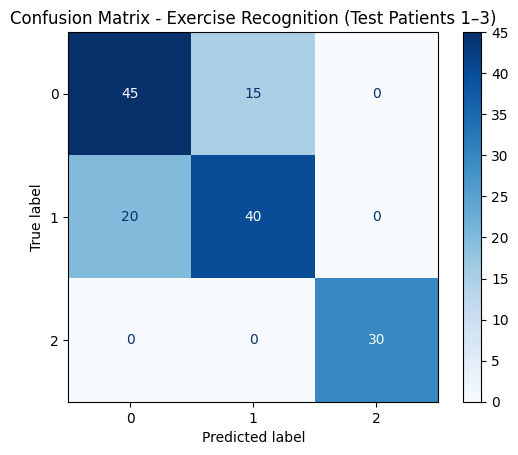

In [105]:
cm = confusion_matrix(Y_test, Y_pred_initial)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2])
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - Exercise Recognition (Test Patients 1–3)")
plt.show()

# Calculate Feature Importance

In [106]:
# === Compute permutation feature importance ===
print("\nComputing permutation feature importance...")
perm_importance = permutation_importance(
    best_model,
    X_test_scaled,
    Y_test,
    scoring='f1_macro',
    n_repeats=50,
    random_state=42,
    n_jobs=-1
)

importances = perm_importance.importances_mean.copy()
sorted_idx = np.argsort(importances)  # from worst to best
remaining_features = list(range(X_train_scaled.shape[1]))



Computing permutation feature importance...



Feature Analysis:
  - Features with NEGATIVE importance (noise): 73
  - Features with POSITIVE importance (useful): 59
  - Features with ZERO importance (neutral): 0
  - Total features: 132

Top 10 WORST features (lowest importance):
  1. Feature 41: -0.021062
  2. Feature 33: -0.019050
  3. Feature 45: -0.016808
  4. Feature 92: -0.015809
  5. Feature 104: -0.015650
  6. Feature 108: -0.015225
  7. Feature 16: -0.013665
  8. Feature 100: -0.013202
  9. Feature 44: -0.012926
  10. Feature 96: -0.011712

Top 10 BEST features (highest importance):
  1. Feature 64: 0.026206
  2. Feature 63: 0.025085
  3. Feature 55: 0.020509
  4. Feature 59: 0.018529
  5. Feature 54: 0.016999
  6. Feature 62: 0.014047
  7. Feature 51: 0.013901
  8. Feature 52: 0.012943
  9. Feature 102: 0.012116
  10. Feature 56: 0.011760


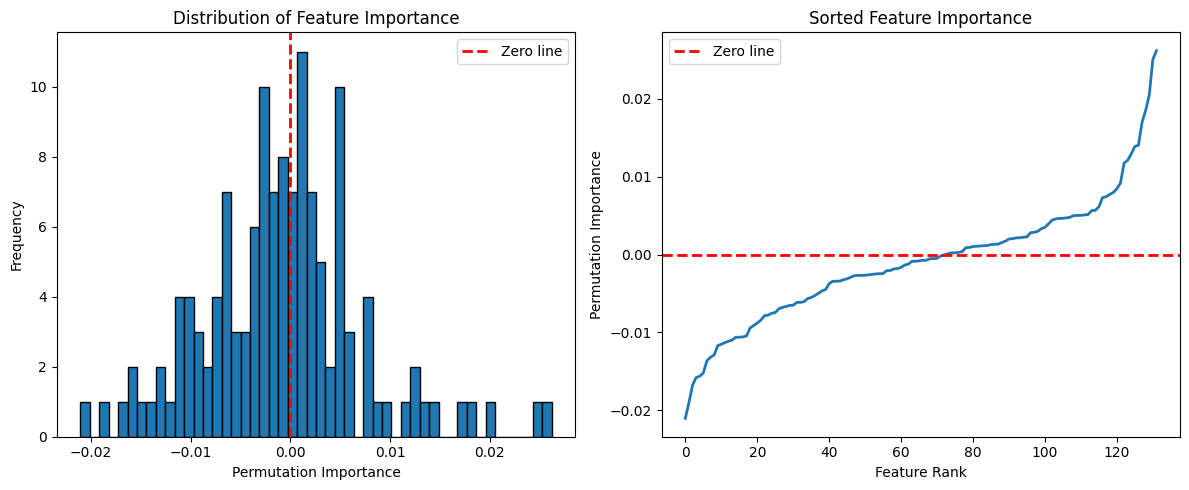

In [107]:
# Identify negative and positive features
negative_features = np.where(perm_importance.importances_mean < 0)[0]
positive_features = np.where(perm_importance.importances_mean > 0)[0]
zero_features = np.where(perm_importance.importances_mean == 0)[0]

print(f"\nFeature Analysis:")
print(f"  - Features with NEGATIVE importance (noise): {len(negative_features)}")
print(f"  - Features with POSITIVE importance (useful): {len(positive_features)}")
print(f"  - Features with ZERO importance (neutral): {len(zero_features)}")
print(f"  - Total features: {X_train_scaled.shape[1]}")

# Find the 10 worst and best features
worst_idx = np.argsort(perm_importance.importances_mean)[:10]
best_idx = np.argsort(perm_importance.importances_mean)[::-1][:10]

print(f"\nTop 10 WORST features (lowest importance):")
for i, idx in enumerate(worst_idx, 1):
    print(f"  {i}. Feature {idx}: {perm_importance.importances_mean[idx]:.6f}")

print(f"\nTop 10 BEST features (highest importance):")
for i, idx in enumerate(best_idx, 1):
    print(f"  {i}. Feature {idx}: {perm_importance.importances_mean[idx]:.6f}")

# Plot importance distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(perm_importance.importances_mean, bins=50, edgecolor='black')
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero line')
plt.xlabel('Permutation Importance')
plt.ylabel('Frequency')
plt.title('Distribution of Feature Importance')
plt.legend()

plt.subplot(1, 2, 2)
sorted_importance = np.sort(perm_importance.importances_mean)
plt.plot(sorted_importance, linewidth=2)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2, label='Zero line')
plt.xlabel('Feature Rank')
plt.ylabel('Permutation Importance')
plt.title('Sorted Feature Importance')
plt.legend()
plt.tight_layout()
plt.show()


Starting progressive feature elimination (1 feature at a time)...



Feature Elimination Progress:  32%|███▏      | 42/131 [08:19<17:37, 11.88s/it, Features Left=91, Test F1=0.8857] 


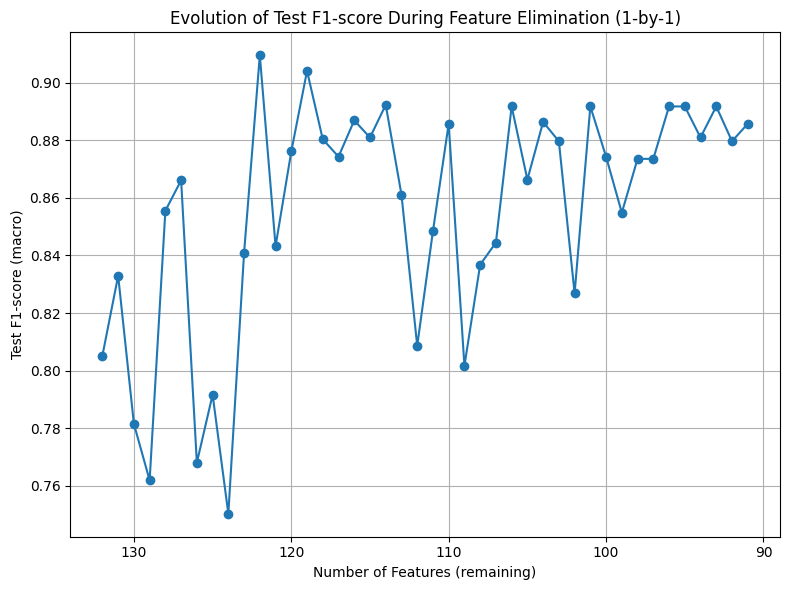

In [108]:
# === Progressive Feature Elimination ===
scores = []
num_features = []
best_f1 = -1
best_model_reduced = None
best_features = None

# Start with best params from initial grid search
current_model = clone(mlp).set_params(**grid_search.best_params_)

print("\nStarting progressive feature elimination (1 feature at a time)...\n")
steps = (len(remaining_features) - 1) // 1
pbar = tqdm(total=steps, desc="Feature Elimination Progress")

while len(remaining_features) > 90:
    # Reduced feature set
    X_train_reduced = X_train_scaled[:, remaining_features]
    X_test_reduced = X_test_scaled[:, remaining_features]
    
    # Retrain model on reduced features
    current_model.fit(X_train_reduced, Y_train)
    
    # Evaluate
    Y_pred = current_model.predict(X_test_reduced)
    f1 = f1_score(Y_test, Y_pred, average='macro')
    
    scores.append(f1)
    num_features.append(len(remaining_features))
    
    pbar.set_postfix({"Features Left": len(remaining_features), "Test F1": f"{f1:.4f}"})
    pbar.update(1)
    
    # Track best model
    if f1 > best_f1:
        best_f1 = f1
        best_model_reduced = copy.deepcopy(current_model)
        best_features = remaining_features.copy()
    
    # Get permutation importance on reduced features
    perm_importance = permutation_importance(
        current_model, 
        X_test_reduced, 
        Y_test, 
        scoring='f1_macro', 
        n_repeats=10, 
        random_state=42
    )
    # Remove the **least important feature**
    worst_feature_idx = np.argmin(perm_importance.importances_mean)
    worst_feature = remaining_features[worst_feature_idx]
    remaining_features.remove(worst_feature)

pbar.close()

# === Plot Evolution of F1 Score ===
plt.figure(figsize=(8, 6))
plt.plot(num_features, scores, marker='o')
plt.gca().invert_xaxis()
plt.xlabel("Number of Features (remaining)")
plt.ylabel("Test F1-score (macro)")
plt.title("Evolution of Test F1-score During Feature Elimination (1-by-1)")
plt.grid(True)
plt.tight_layout()
plt.show()


Best reduced model achieved F1 = 0.9095 with 122 features.


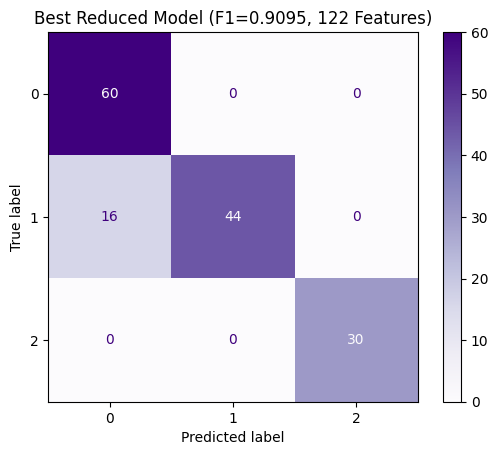

In [116]:
# === Evaluate Best Reduced Model ===
print(f"\nBest reduced model achieved F1 = {best_f1:.4f} with {len(best_features)} features.")

X_train_best = X_train_scaled[:, best_features]
X_test_best = X_test_scaled[:, best_features]
Y_pred_best = best_model_reduced.predict(X_test_best)

cm_best = confusion_matrix(Y_test, Y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_best, display_labels=[0, 1, 2])
disp.plot(cmap='Purples', values_format='d')
plt.title(f"Best Reduced Model (F1={best_f1:.4f}, {len(best_features)} Features)")
plt.show()


# Champion after features Removal

In [118]:
# === Prepare reduced feature sets ===
X_train_best = X_train_scaled[:, best_features]
X_test_best = X_test_scaled[:, best_features]

# Define MLP model
mlp_reduced = MLPClassifier(max_iter=600, random_state=42)

# Same hyperparameter grid
param_grid = {
    'hidden_layer_sizes': [(64,), (128,), (128, 64), (256, 128)],
    'alpha': [0.00001, 0.0001, 0.001],
    'learning_rate_init': [0.001, 0.01],
    'activation': ['relu', 'tanh']
}

# Leave-One-Group-Out CV
cv = LeaveOneGroupOut()

grid_search_reduced = GridSearchCV(
    estimator=mlp_reduced,
    param_grid=param_grid,
    cv=cv.split(X_train_best, Y_train, groups=groups_train),
    scoring='f1_macro',
    n_jobs=-1,
    verbose=2
)


In [119]:
# Run grid search
print("\nRunning grid search on best reduced feature set...")
grid_search_reduced.fit(X_train_best, Y_train)


print("\nBest parameters for reduced model:")
print(grid_search_reduced.best_params_)
print(f"Best CV F1-macro: {grid_search_reduced.best_score_:.4f}")


Running grid search on best reduced feature set...
Fitting 11 folds for each of 48 candidates, totalling 528 fits


[CV] END activation=relu, alpha=1e-05, hidden_layer_sizes=(64,), learning_rate_init=0.01; total time=   0.1s
[CV] END activation=relu, alpha=1e-05, hidden_layer_sizes=(64,), learning_rate_init=0.001; total time=   0.5s
[CV] END activation=relu, alpha=1e-05, hidden_layer_sizes=(64,), learning_rate_init=0.001; total time=   0.5s
[CV] END activation=relu, alpha=1e-05, hidden_layer_sizes=(64,), learning_rate_init=0.001; total time=   0.5s
[CV] END activation=relu, alpha=1e-05, hidden_layer_sizes=(64,), learning_rate_init=0.01; total time=   0.2s
[CV] END activation=relu, alpha=1e-05, hidden_layer_sizes=(64,), learning_rate_init=0.01; total time=   0.2s
[CV] END activation=relu, alpha=1e-05, hidden_layer_sizes=(64,), learning_rate_init=0.01; total time=   0.2s
[CV] END activation=relu, alpha=1e-05, hidden_layer_sizes=(64,), learning_rate_init=0.001; total time=   0.4s
[CV] END activation=relu, alpha=1e-05, hidden_layer_sizes=(64,), learning_rate_init=0.01; total time=   0.2s
[CV] END activa

In [120]:
# Evaluate on test set
best_model_reduced_final = grid_search_reduced.best_estimator_
Y_pred_best_final = best_model_reduced_final.predict(X_test_best)
f1_best_final = f1_score(Y_test, Y_pred_best_final, average='macro')

print(f"\nTest F1-score (macro) for reduced model: {f1_best_final:.4f}")


Test F1-score (macro) for reduced model: 0.9095


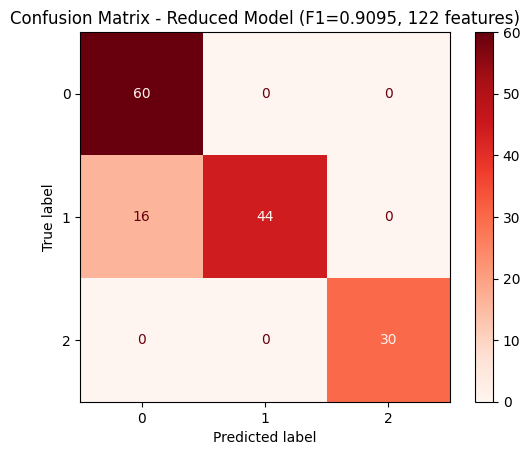

In [121]:
# Confusion matrix
cm_best_final = confusion_matrix(Y_test, Y_pred_best_final)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_best_final, display_labels=[0, 1, 2])
disp.plot(cmap='Reds', values_format='d')
plt.title(f"Confusion Matrix - Reduced Model (F1={f1_best_final:.4f}, {len(best_features)} features)")
plt.show()

In [ ]:
print(best_features)
np.save("Validation/best_features_mlp.npy", np.array(best_features))


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 38, 39, 40, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 93, 94, 95, 96, 97, 99, 101, 103, 105, 106, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131]
